# Определение возраста покупателей

## Исследовательский анализ данных

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.


`Задача:`  построить модель, которая по фотографии определит приблизительный возраст человека. 

`Входные данные:` набор фотографий людей с указанием возраста.

In [1]:
import pandas as pd
from tensorflow.keras.models import Sequential
import numpy as np
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from sklearn.metrics import mean_squared_error as mse

#optimizer = Adam(learning_rate=0.001)
from sklearn.metrics import mean_absolute_error as mae 

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.shape

(7591, 2)

<AxesSubplot:>

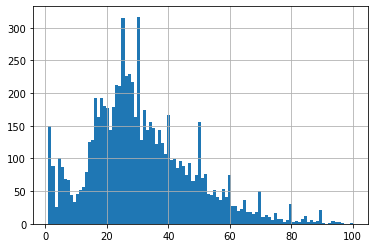

In [5]:
labels['real_age'].hist(bins=100)

In [9]:
path = '/datasets/faces/'

In [10]:
train_datagen = ImageDataGenerator(rescale=1/255.,validation_split=0.25,vertical_flip=True,horizontal_flip=True,width_shift_range=0.2,height_shift_range=0.2)

train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path+ 'labels.csv'),
        directory=(path+'/final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

Found 5694 validated image filenames.


In [11]:
test_datagen = ImageDataGenerator(rescale=1/255.,validation_split=0.25)

test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path+ 'labels.csv'),
        directory=(path+'/final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
  

Found 1897 validated image filenames.


In [12]:
features,target= next(train_datagen_flow)

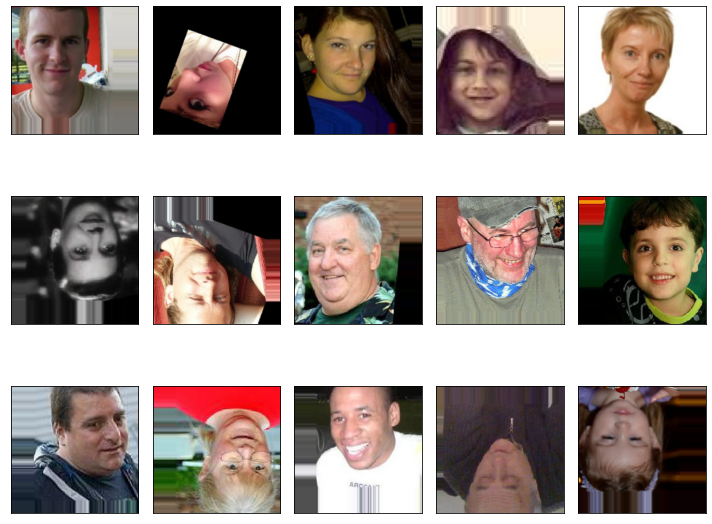

In [13]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод:

Объем предложенной выборки 7591. Для задачи данных недостаточно, в предобработке следует использовать аугментацию.

Данные имеют небольшие выбросы в области [90,100].

Распределение данных не симметрично, фото людей старшего возрасто предоставленны в значительн меньшем кол-ве. 

Пики в области ~1,25,30 лет. Возможно большая часть фото была собрана из каких-либо соцсетей, где обычно представлены в большей части люди 20-40 лет, и также их публикации, возможно, включали фото их детей. 

В целом пики наблюдается на целых цифрах возраста: 30-40-50-60-70-80. Возможно какое-то округление в анкетах.

В связи с задачей контингент до ~10 лет не так интересен, возможно стоило эти данные исключить.

Из просмотренных примеров фото, можно сказать что фото собраны из разных источников, в целом очень разные по яркости. контрастности, четкости и ракурсам. Имеются изображения как 3-х канальные так и чб.

## Обучение модели

Ниже представлен код обучения модели.

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):
    train_datagen = ImageDataGenerator(rescale=1/255.,validation_split=0.25,vertical_flip=True,horizontal_flip=True,width_shift_range=0.2,height_shift_range=0.2)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path+ 'labels.csv'),
        directory=(path+'/final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
  
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1/255.,validation_split=0.25)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path+ 'labels.csv'),
        directory=(path+'/final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
  
    return test_datagen_flow

def create_model(input_shape):
  
    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet', 
                    include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
    validation_data=test_data,
    batch_size=batch_size, 
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=2)

    return model 

```

Вывод:

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 99s - loss: 267.2777 - mae: 11.9497 - val_loss: 540.6625 - val_mae: 18.2202
Epoch 2/10
178/178 - 96s - loss: 115.6391 - mae: 8.1672 - val_loss: 573.1235 - val_mae: 18.7315
Epoch 3/10
178/178 - 89s - loss: 97.7595 - mae: 7.5187 - val_loss: 328.9346 - val_mae: 13.5026
Epoch 4/10
178/178 - 95s - loss: 81.7256 - mae: 6.8533 - val_loss: 138.0943 - val_mae: 9.0227
Epoch 5/10
178/178 - 92s - loss: 73.5475 - mae: 6.5440 - val_loss: 183.1078 - val_mae: 10.6586
Epoch 6/10
178/178 - 90s - loss: 64.5454 - mae: 6.1257 - val_loss: 92.0726 - val_mae: 7.3826
Epoch 7/10
178/178 - 94s - loss: 60.3684 - mae: 5.9074 - val_loss: 102.9014 - val_mae: 7.5951
Epoch 8/10
178/178 - 95s - loss: 51.2033 - mae: 5.4945 - val_loss: 90.6894 - val_mae: 7.0948
Epoch 9/10
178/178 - 90s - loss: 49.4452 - mae: 5.3617 - val_loss: 89.7486 - val_mae: 6.9105
Epoch 10/10
178/178 - 94s - loss: 46.7563 - mae: 5.2646 - val_loss: 101.9715 - val_mae: 7.2821


60/60 - 10s - loss: 101.9715 - mae: 7.2821
Test MAE: 7.2821
```

## Анализ обученной модели

В работе была построена модель на основе предобученной модели ResNet50, с добавлением GlobalAveragePooling2D и полносвязным слоем с единственным выходом (возраст) и функцией активации relu. 

Также была сделана аугментации на тренировочных данны: горизонтальный\вертикальный поворот и смещения. 

Средняя абсолютная ошибка обученной модели составила ~7.2821

На основе полученного результата можно сказать, что построенная модель будет достаточно точно определять возраст людей, что позволит решать задачи рекомендации актуальных товаров и контроля продажи алкогольной продукции несовершеннолетним. 